<a href="https://colab.research.google.com/github/ShyamSundhar1411/ANN/blob/master/GroundNut_Leaf_Detection_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchinfo
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
!mv /content/helper_functions.py.1 /content/functions.py

--2023-11-30 09:09:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-30 09:09:14 (140 MB/s) - ‘helper_functions.py’ saved [10246/10246]

--2023-11-30 09:09:14--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response.

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir,calculate_results,make_confusion_matrix
from tensorflow.keras.utils import plot_model

In [ ]:
train_dir = 'Groundnut_Leaf_dataset/train'
test_dir = 'Groundnut_Leaf_dataset/test'

In [ ]:
unzip_data('/content/drive/MyDrive/Groundnut_Leaf_dataset.zip')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
from data_setup import create_dataloaders
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    transform=train_transforms,
                                                                    batch_size=32)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import torchvision

In [ ]:
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

In [ ]:
model = torchvision.models.densenet161(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 81.7MB/s]


In [ ]:
for param in model.parameters():
    param.requires_grad = False

in_features = model.classifier.in_features

model.classifier = nn.Linear(in_features, 6)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
device

'cuda'

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import engine
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,matthews_corrcoef

def evaluate_classification_model(model, dataloader,device):

    predictions = []
    model.eval()
    with torch.inference_mode():  # Disable gradient calculation
        for batch,(X,y) in enumerate(dataloader):
            inputs = X.to(device)  # Send data to the device (CPU or GPU)
            outputs = model(inputs)    # Forward pass to get predictions
            predictions.append(outputs)
    true_labels = []  # Initialize an empty list to store true labels
    predictions = torch.cat(predictions, dim=0)
    probabilities = torch.softmax(predictions, dim=1)
    _, predicted_labels = torch.max(probabilities, dim=1)
    predicted_labels = predicted_labels.to("cpu")
    for batch,(X,y) in enumerate(dataloader):
        for labels in y:# Iterate through the dataset
            true_labels.append(labels)

    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels,average='weighted')
    accuracy = accuracy_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels,predicted_labels)
    return {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'MCC':mcc,
        'Accuracy': accuracy
    }

In [ ]:
evaluate_classification_model(model,test_dataloader,device)

{'Precision': 0.9214596065524059,
 'Recall': 0.9184006527947777,
 'F1-Score': 0.9183054164380409,
 'MCC': 0.9027582459507163,
 'Accuracy': 0.9184006527947777}

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
def plot_confusion_matrix(model,data,class_names,name):


    predictions = []
    model.eval()
    with torch.inference_mode():  # Disable gradient calculation
        for batch,(X,y) in enumerate(data):
            inputs = X.to(device)  # Send data to the device (CPU or GPU)
            outputs = model(inputs)    # Forward pass to get predictions
            predictions.append(outputs)
    true_labels = []  # Initialize an empty list to store true labels

    for batch,(X,y) in enumerate(data):
        for labels in y:# Iterate through the dataset
            true_labels.append(labels)
    # Concatenate predictions for all batches
    predictions = torch.cat(predictions, dim=0)
    probabilities = torch.softmax(predictions, dim=1)
    _, predicted_labels = torch.max(probabilities, dim=1)
    predicted_labels = predicted_labels.to("cpu")
    cm = confusion_matrix(true_labels, predicted_labels)
    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust the font size for better visualization
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig("./cm_"+name+".png")
    plt.show()


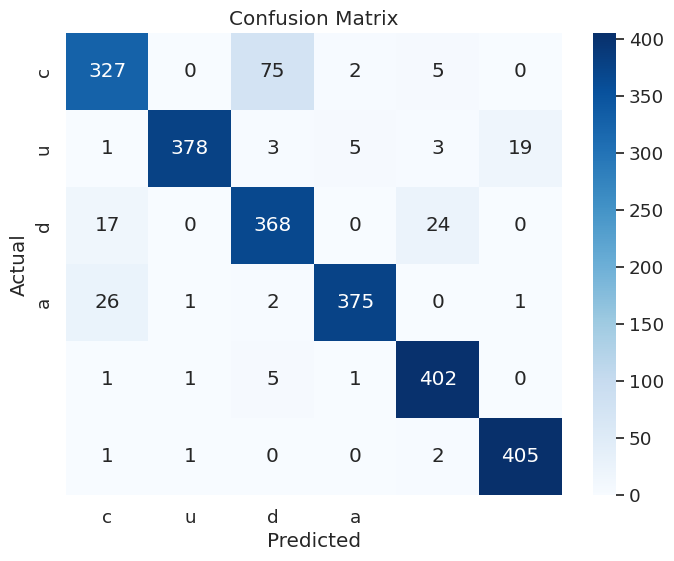

In [ ]:
plot_confusion_matrix(model,test_dataloader,device,name="densenet")

In [ ]:
def plot_loss_accuracy_curve(history):
    epochs = range(len(results["train_loss"]))
    train_losses = history['train_loss']
    train_accuracies = history['train_acc']

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(epochs, train_losses, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Train Accuracy (%)', color=color)
    ax2.plot(epochs, train_accuracies, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('Training Loss and TTrain Accuracy Curves')
    plt.savefig("./training_curves_efficientnet_fl.png")
    plt.show()

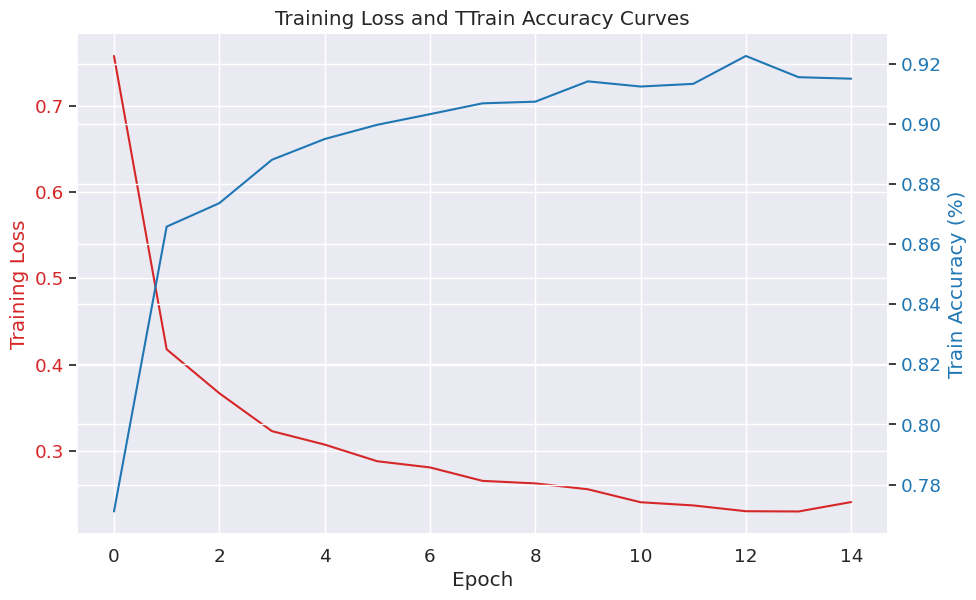

In [ ]:
plot_loss_accuracy_curve(results)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
def plot_roc_curve(model,test_dataloader,name):

    y_score = []
    model.eval()
    with torch.inference_mode():  # Disable gradient calculation
        for batch,(X,y) in enumerate(test_dataloader):
            inputs = X.to(device)  # Send data to the device (CPU or GPU)
            outputs = model(inputs)    # Forward pass to get y_scores
            y_score.append(outputs)

    true_labels = []
    for batch,(X,y) in enumerate(test_dataloader):
        for labels in y:# Iterate through the dataset
            true_labels.append(labels)
    # Concatenate y_scores for all batches
    y_score = torch.cat(y_score, dim=0)
    # Binarize the true labels (one-hot encoding)
    n_classes = 6
    y_test_bin = label_binarize(true_labels,classes=np.arange(n_classes))
    y_score = y_score.to("cpu")
    # Initialize variables for ROC curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for each class
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])  # You can add more colors if needed
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
    plt.legend(loc='lower right')
    plt.savefig("./roc_curve_"+name+".png")
    plt.show()


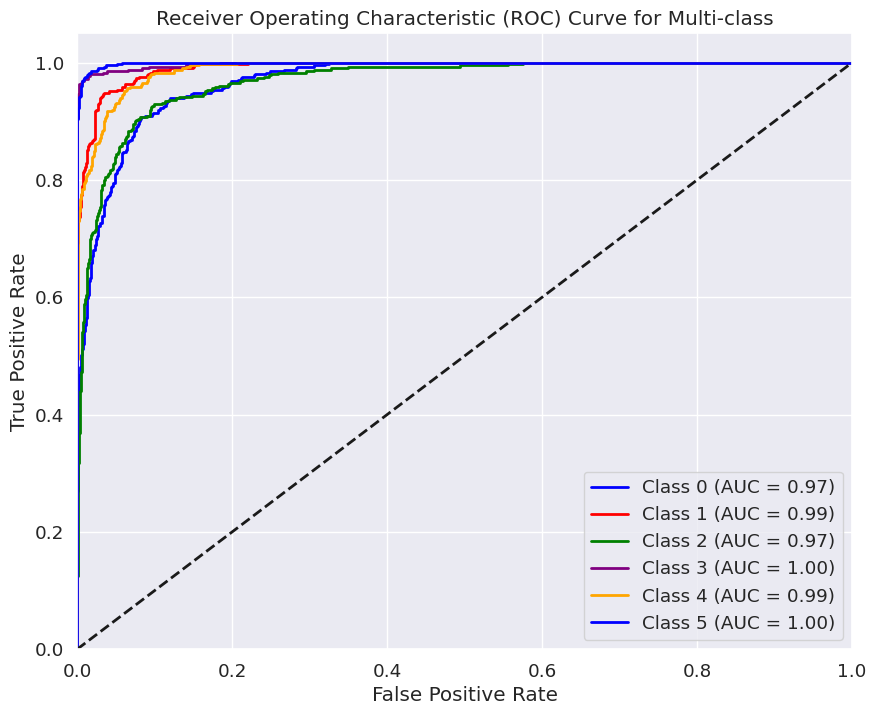

In [ ]:
plot_roc_curve(model,test_dataloader,name="densenet")

## Focal Loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, logits=True, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        else:
            inputs = inputs.log_softmax(dim=1)
            CE_loss = F.nll_loss(inputs, targets, reduction='none')

        pt = torch.exp(-CE_loss)
        F_loss = (1 - pt)**self.gamma * CE_loss

        if self.alpha is not None:
            F_loss = self.alpha[targets] * F_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [ ]:
loss_fn = FocalLoss()

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import engine
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3725 | train_acc: 0.7775 | test_loss: 0.1456 | test_acc: 0.9004
Epoch: 2 | train_loss: 0.1728 | train_acc: 0.8695 | test_loss: 0.1290 | test_acc: 0.8929
Epoch: 3 | train_loss: 0.1539 | train_acc: 0.8769 | test_loss: 0.1124 | test_acc: 0.9083
Epoch: 4 | train_loss: 0.1329 | train_acc: 0.8876 | test_loss: 0.0916 | test_acc: 0.9060
Epoch: 5 | train_loss: 0.1255 | train_acc: 0.8914 | test_loss: 0.1187 | test_acc: 0.8937
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.8957 | test_loss: 0.0837 | test_acc: 0.9200
Epoch: 7 | train_loss: 0.1155 | train_acc: 0.9041 | test_loss: 0.1026 | test_acc: 0.8964
Epoch: 8 | train_loss: 0.1131 | train_acc: 0.9047 | test_loss: 0.1035 | test_acc: 0.9164
Epoch: 9 | train_loss: 0.1151 | train_acc: 0.8974 | test_loss: 0.0897 | test_acc: 0.9245
Epoch: 10 | train_loss: 0.1090 | train_acc: 0.9062 | test_loss: 0.1110 | test_acc: 0.9085
Epoch: 11 | train_loss: 0.1017 | train_acc: 0.9080 | test_loss: 0.0757 | test_acc: 0.9318
Epoch: 12 | train_l

In [ ]:
evaluate_classification_model(model,test_dataloader,device)

{'Precision': 0.9205215755323674,
 'Recall': 0.9147286821705426,
 'F1-Score': 0.9146781477368591,
 'MCC': 0.8989479897086976,
 'Accuracy': 0.9147286821705426}

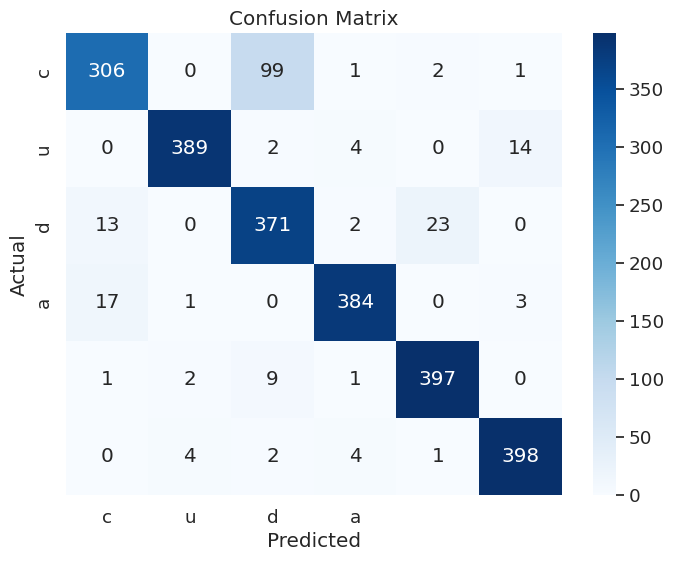

In [ ]:
plot_confusion_matrix(model,test_dataloader,device,name="densenet_fl")

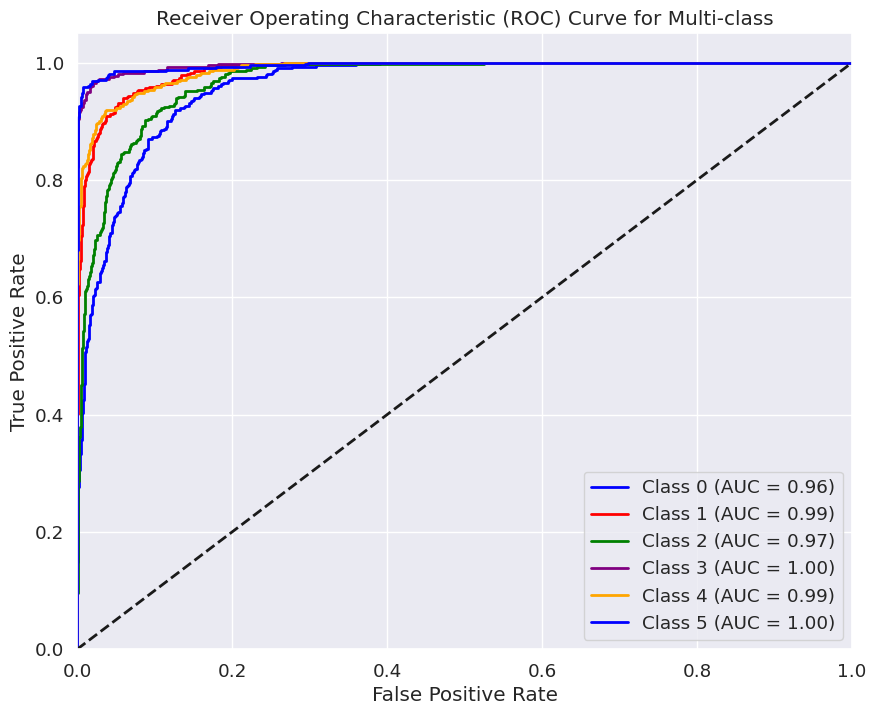

In [ ]:
plot_roc_curve(model,test_dataloader,name="densenet_fl")

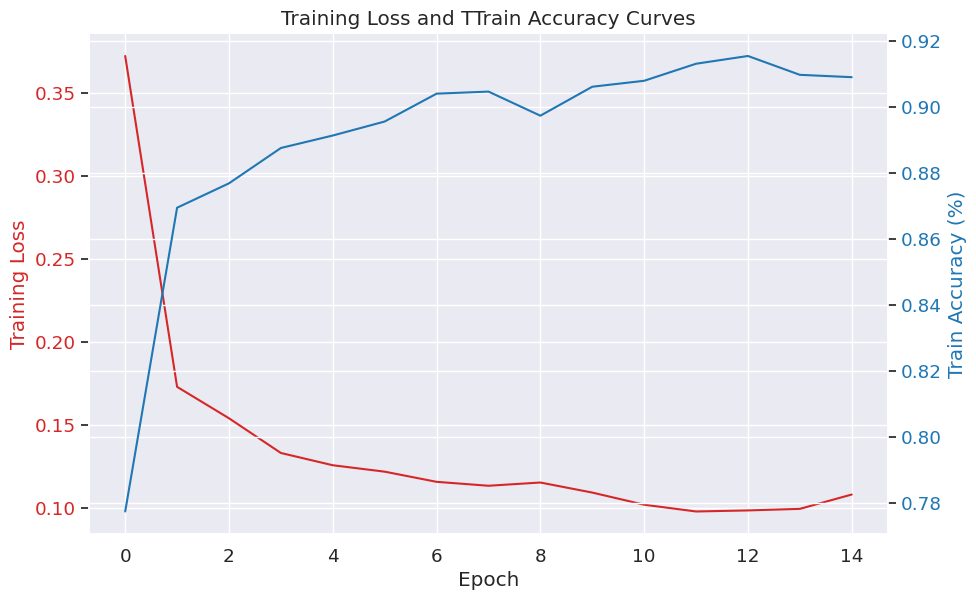

In [ ]:
plot_loss_accuracy_curve(results)

## EfficientNet B7

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.9 MB/s eta 0:00:00


In [ ]:
import timm

In [ ]:
model = timm.create_model('efficientnet_b5', pretrained=True)
num_ftrs = model.classifier.in_features

In [ ]:
model.classifier = nn.Linear(num_ftrs, 6)

In [ ]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import engine
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7560 | train_acc: 0.7319 | test_loss: 0.8843 | test_acc: 0.7700
Epoch: 2 | train_loss: 0.4887 | train_acc: 0.8262 | test_loss: 0.4296 | test_acc: 0.8382
Epoch: 3 | train_loss: 0.4085 | train_acc: 0.8506 | test_loss: 0.4140 | test_acc: 0.8475
Epoch: 4 | train_loss: 0.3547 | train_acc: 0.8704 | test_loss: 0.2935 | test_acc: 0.8980
Epoch: 5 | train_loss: 0.3412 | train_acc: 0.8782 | test_loss: 0.2028 | test_acc: 0.9290
Epoch: 6 | train_loss: 0.2754 | train_acc: 0.9017 | test_loss: 0.3560 | test_acc: 0.8770
Epoch: 7 | train_loss: 0.2541 | train_acc: 0.9107 | test_loss: 0.2112 | test_acc: 0.9209
Epoch: 8 | train_loss: 0.2700 | train_acc: 0.9055 | test_loss: 0.3358 | test_acc: 0.8689
Epoch: 9 | train_loss: 0.2464 | train_acc: 0.9130 | test_loss: 0.2920 | test_acc: 0.9015
Epoch: 10 | train_loss: 0.2237 | train_acc: 0.9208 | test_loss: 0.3595 | test_acc: 0.8847
Epoch: 11 | train_loss: 0.2275 | train_acc: 0.9201 | test_loss: 0.1612 | test_acc: 0.9485
Epoch: 12 | train_l

In [ ]:
evaluate_classification_model(model,test_dataloader,device)

{'Precision': 0.9315579700354419,
 'Recall': 0.9257445940432476,
 'F1-Score': 0.925827125175168,
 'MCC': 0.9119954237275206,
 'Accuracy': 0.9257445940432476}

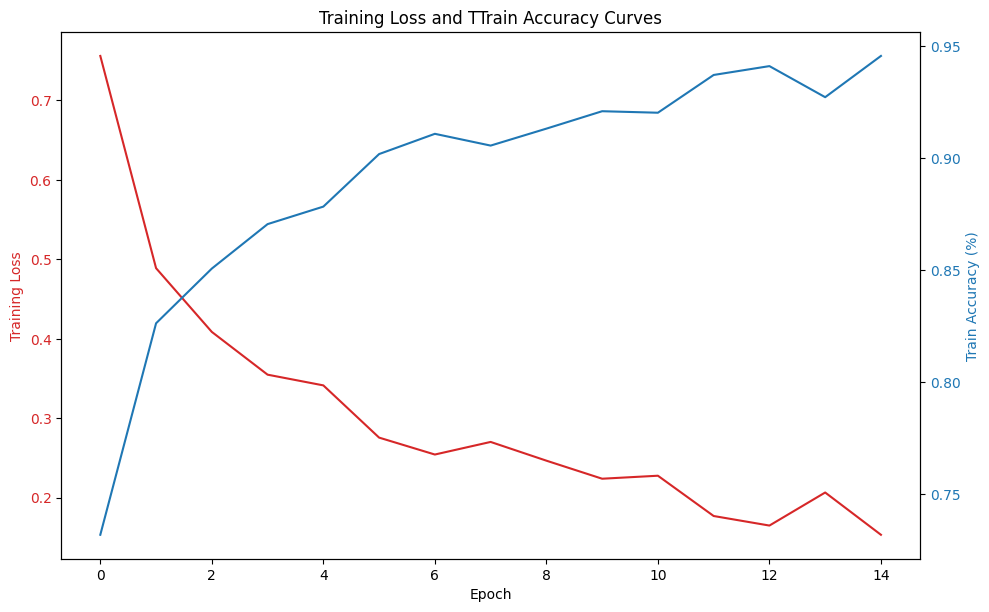

In [ ]:
plot_loss_accuracy_curve(results)

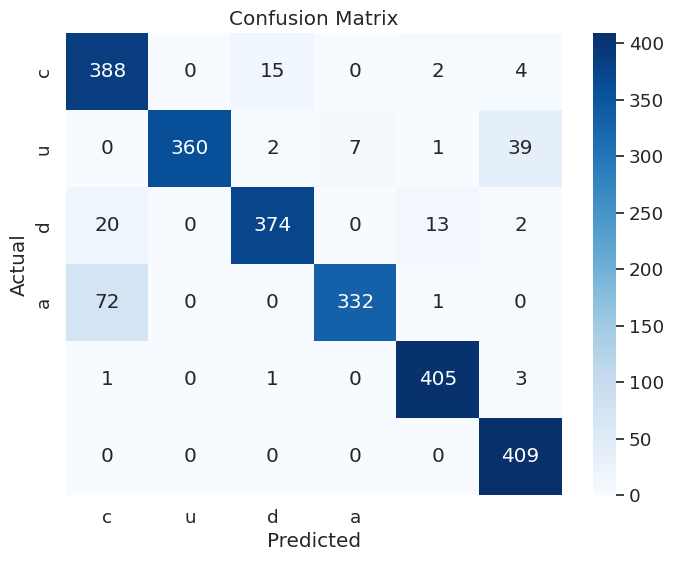

In [ ]:
plot_confusion_matrix(model,test_dataloader,device,name="efficientnet_b5")

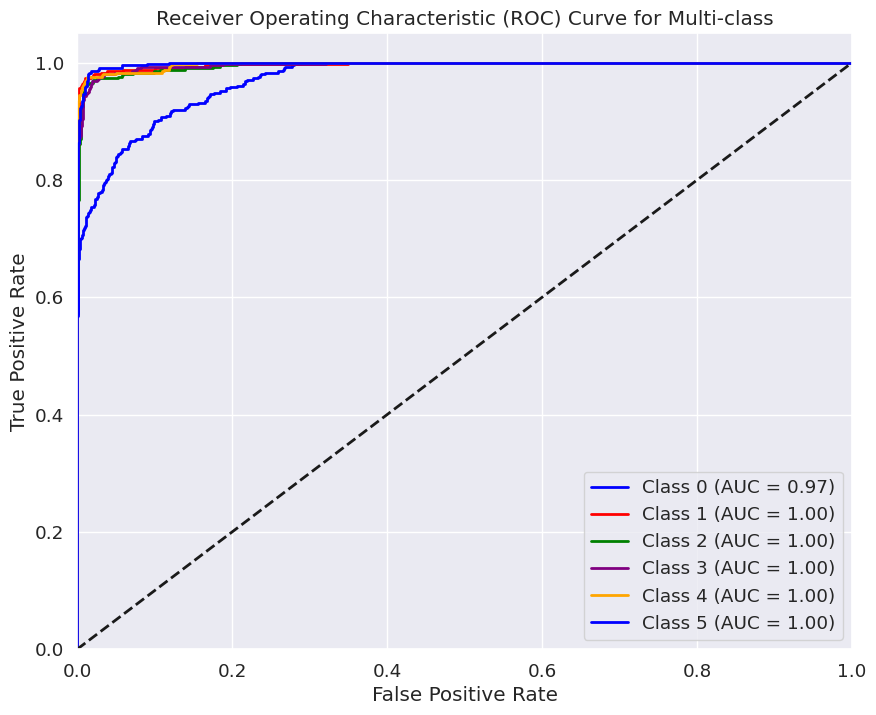

In [ ]:
plot_roc_curve(model,test_dataloader,name="efficientnet_b5")

## Focal Loss EfficientNet

In [ ]:
model = timm.create_model('efficientnet_b5', pretrained=True)
num_ftrs = model.classifier.in_features

In [ ]:
model.classifier = nn.Linear(num_ftrs, 6)

In [ ]:
loss_fn = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import engine
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4216 | train_acc: 0.7178 | test_loss: 0.3141 | test_acc: 0.7792
Epoch: 2 | train_loss: 0.2458 | train_acc: 0.8012 | test_loss: 0.1570 | test_acc: 0.8970
Epoch: 3 | train_loss: 0.1877 | train_acc: 0.8439 | test_loss: 0.1479 | test_acc: 0.8640
Epoch: 4 | train_loss: 0.1685 | train_acc: 0.8538 | test_loss: 0.1565 | test_acc: 0.8558
Epoch: 5 | train_loss: 0.1457 | train_acc: 0.8726 | test_loss: 0.1350 | test_acc: 0.8904
Epoch: 6 | train_loss: 0.1348 | train_acc: 0.8849 | test_loss: 0.1871 | test_acc: 0.8872
Epoch: 7 | train_loss: 0.1134 | train_acc: 0.8956 | test_loss: 0.1573 | test_acc: 0.8443
Epoch: 8 | train_loss: 0.1191 | train_acc: 0.8896 | test_loss: 0.1043 | test_acc: 0.8888
Epoch: 9 | train_loss: 0.1003 | train_acc: 0.9107 | test_loss: 0.1208 | test_acc: 0.8778
Epoch: 10 | train_loss: 0.1010 | train_acc: 0.9064 | test_loss: 0.0826 | test_acc: 0.9148
Epoch: 11 | train_loss: 0.0958 | train_acc: 0.9124 | test_loss: 0.0906 | test_acc: 0.9298
Epoch: 12 | train_l

In [ ]:
evaluate_classification_model(model,test_dataloader,device)

{'Precision': 0.9428098990265296,
 'Recall': 0.9408404732762138,
 'F1-Score': 0.9406471368414401,
 'MCC': 0.9295040798234434,
 'Accuracy': 0.9408404732762138}

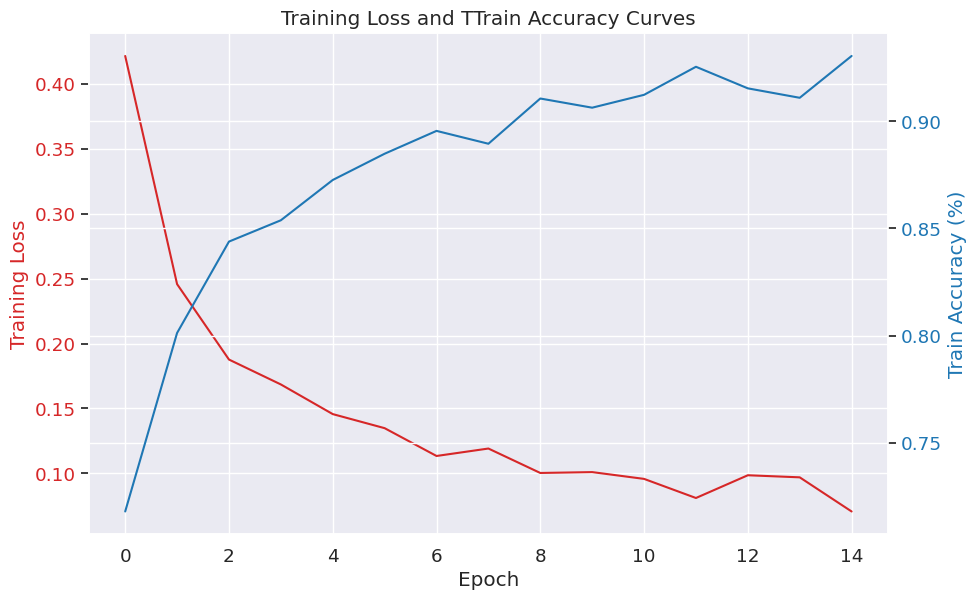

In [ ]:
plot_loss_accuracy_curve(results)

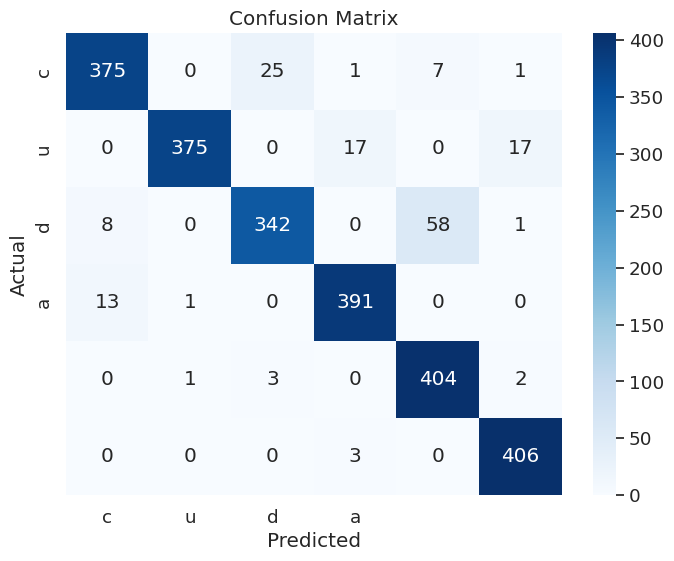

In [ ]:
plot_confusion_matrix(model,test_dataloader,device,name="efficientnet_b5_fl")

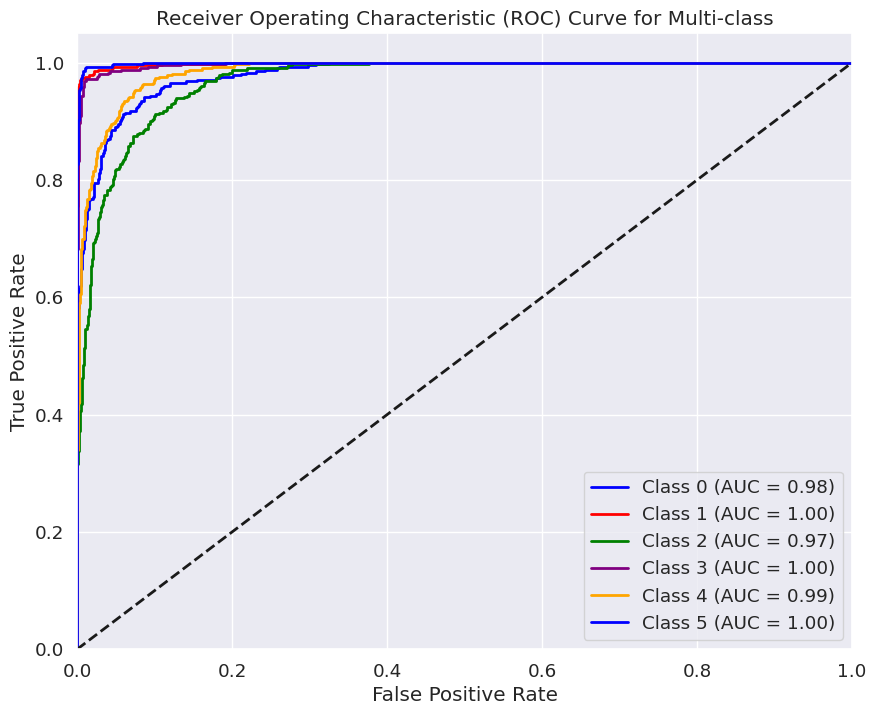

In [ ]:
plot_roc_curve(model,test_dataloader,name="efficientnet_b5_fl")